# Human Activity Recognition

In [70]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [71]:
feature_name_df = pd.read_csv('../00.data/UCI_HAR_Dataset/features.txt', sep='\s+', header=None, names=['col_index','col_name'])
feature_name_df.head()

,col_index,col_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [72]:
feature_dup_df = feature_name_df.groupby('col_name').count()
feature_dup_df.head()

,col_index
col_name,
"angle(X,gravityMean)",1
"angle(Y,gravityMean)",1
"angle(Z,gravityMean)",1
"angle(tBodyAccJerkMean),gravityMean)",1
"angle(tBodyAccMean,gravity)",1


In [73]:
feature_dup_df[feature_dup_df['col_index'] > 1].count()
# feature_name에서 1개이상인것..중복된것이 42개있다.

col_index    42
dtype: int64

In [74]:
feature_dup_df[feature_dup_df['col_index'] > 1].head()

,col_index
col_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [34]:
feature_cum_df = pd.DataFrame({'dup_cnt':feature_name_df.groupby('col_name').cumcount()})#요기포인트! 중복되는것에 cumcount()1,2,3붙게
feature_cum_df.reset_index(inplace=True)
feature_cum_df.head()

,index,dup_cnt
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [35]:
feature_name_df.head()

,col_index,col_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [36]:
new_df = pd.merge(feature_name_df.reset_index(), feature_cum_df)
new_df.head()

,index,col_index,col_name,dup_cnt
0,0,1,tBodyAcc-mean()-X,0
1,1,2,tBodyAcc-mean()-Y,0
2,2,3,tBodyAcc-mean()-Z,0
3,3,4,tBodyAcc-std()-X,0
4,4,5,tBodyAcc-std()-Y,0


In [37]:
# 람다; _언더바에 1보다크면붙이고, 만약0이면말고
new_df['col_name'] = new_df[['col_name', 'dup_cnt']].\
    apply(lambda x: x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
new_df.head()

,index,col_index,col_name,dup_cnt
0,0,1,tBodyAcc-mean()-X,0
1,1,2,tBodyAcc-mean()-Y,0
2,2,3,tBodyAcc-mean()-Z,0
3,3,4,tBodyAcc-std()-X,0
4,4,5,tBodyAcc-std()-Y,0


In [38]:
new_df = new_df.drop(['index'], axis=1)
new_df.head()

,col_index,col_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0


In [39]:
#위과정으로 알았으니까; 다시 처음부터 과정을 함수로만듦;...
def get_new_feature_name_df(old_df):
    dup_df = pd.DataFrame({'dup_cnt':feature_name_df.groupby('col_name').cumcount()})
    new_df = pd.merge(old_df.reset_index(), dup_df.reset_index())
    new_df['col_name'] = new_df[['col_name', 'dup_cnt']].\
        apply(lambda x: x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_df = new_df.drop(['index'], axis=1)
    return new_df

In [40]:
new_feature_df = get_new_feature_name_df(feature_name_df)
new_feature_df.head()

,col_index,col_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0


In [41]:
feature_list = list(new_feature_df.col_name.values)
feature_list[:10]  #함수로 만들어냈다... feature_list ㅎㄷㄷ 아래와같이 feature_list라는 names를 주기위해 위에 과정을 한것이다!

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

In [42]:
X_train = pd.read_csv('../00.data/UCI_HAR_Dataset/train/X_train.txt', 
                      header=None, sep='\s+', names=feature_list)
X_test = pd.read_csv('../00.data/UCI_HAR_Dataset/test/X_test.txt', 
                     header=None, sep='\s+', names=feature_list)
y_train = pd.read_csv('../00.data/UCI_HAR_Dataset/train/y_train.txt', 
                      header=None, sep='\s+', names=['action'])
y_test = pd.read_csv('../00.data/UCI_HAR_Dataset/test/y_test.txt', 
                     header=None, sep='\s+', names=['action'])

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

## DecisionTreeClassifier로 학습/예측/평가 수행

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [76]:
#아무 옵션없이 랜덤만 주고 돌리니 결정트리예측정확도 0.8548나왔다(cv쓰지않은경우.)
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'결정트리예측정확도: {acc:.4f}')

결정트리예측정확도: 0.8548


In [77]:
dt_clf.get_params() #하이퍼파라미터 확인

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 156,
 'splitter': 'best'}

## GridSearchCV로 최적의 하이퍼 파라미터 도출

In [78]:
from sklearn.model_selection import GridSearchCV

- max_depth 도출

In [79]:
params = {
    'max_depth': [6, 8, 10, 12, 16, 20]
}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'최고 평균 정확도: {grid_cv.best_score_:.4f}')
print('최적 파라미터:', grid_cv.best_params_)
#1.3분소요ㅋ평균정확도 0.8513 최적파라미터 'max_depth': 16
#정확도를위해 cv교차검증 사용 (과적합을 피하기위해! cv교차검증도했고, 제약max_depth도 준것임

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.3min finished
최고 평균 정확도: 0.8513
최적 파라미터: {'max_depth': 16}


In [82]:
df = pd.DataFrame(grid_cv.cv_results_) #cv_results_에 데이터들어있으니, mean_test_score가 어떤지 확인
df = df[['param_max_depth', 'mean_test_score']]
df

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800


In [83]:
params = {
    'max_depth': [14, 16, 18]
}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'최고 평균 정확도: {grid_cv.best_score_:.4f}')
print('최적 파라미터:', grid_cv.best_params_)
#1분소요ㅋ평균정확도 0.8513 최적파라미터 'max_depth': 16

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   44.6s finished
최고 평균 정확도: 0.8513
최적 파라미터: {'max_depth': 16}


In [84]:
df = pd.DataFrame(grid_cv.cv_results_)
df = df[['param_max_depth', 'mean_test_score']]
df

,param_max_depth,mean_test_score
0,14,0.847808
1,16,0.851344
2,18,0.851072


- min_samples_split 도출

In [85]:
params = {
    'max_depth': [8, 12, 16, 18],
    'min_samples_split': [12, 16, 20, 24]
}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'최고 평균 정확도: {grid_cv.best_score_:.4f}')
print('최적 파라미터:', grid_cv.best_params_)
#5분소요ㅋ평균정확도 0.8513 최적파라미터 'max_depth': 16

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.6min finished
최고 평균 정확도: 0.8549
최적 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [86]:
df = pd.DataFrame(grid_cv.cv_results_)
df = df[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]
df

,param_max_depth,param_min_samples_split,mean_test_score
0,8,12,0.852566
1,8,16,0.854879
2,8,20,0.852567
3,8,24,0.851342
4,12,12,0.848623
5,12,16,0.845768
6,12,20,0.846175
7,12,24,0.846175
8,16,12,0.844543
9,16,16,0.847127


## 최적 모델

In [87]:
best_dt_clf = grid_cv.best_estimator_
pred = best_dt_clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'테스트 셋에 대한 정확도: {acc:.4f}')

테스트 셋에 대한 정확도: 0.8717


## 중요도가 높은 Feature 시각화

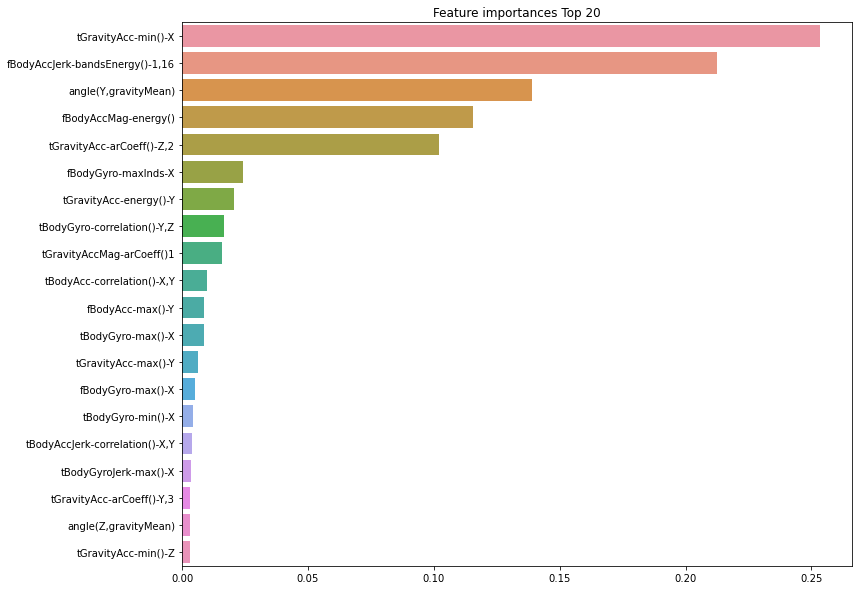

In [88]:
import seaborn as sns

feature_importances = pd.Series(best_dt_clf.feature_importances_, index=feature_list)
top20_feature = feature_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(12,10))
plt.title('Feature importances Top 20')
sns.barplot(x=top20_feature, y=top20_feature.index)
plt.show()

## Graphviz 시각화
vs코드 익스텐션에서 graphviz 검색  
Graphviz (dot) language support for Visual Studio(joao pinto)익스텐션설치  
tree.dot파일열고 Ctrl+Shift+V

In [89]:
target_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 
                'SITTING', 'STANDING', 'LAYING']

In [90]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함. 
export_graphviz(best_dt_clf, out_file="tree.dot", class_names=target_names,
                feature_names=feature_list, impurity=True, filled=True)

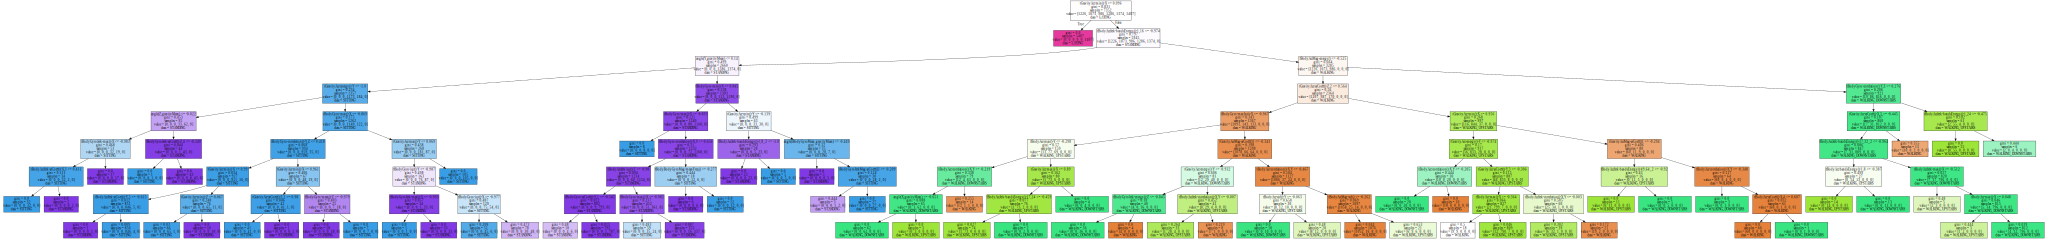

In [91]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)